# Work under process

In [1]:
import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree

import optax

from nn import SIREN, fit, Encoder
from utils import pool_image, get_coords_for_image

import matplotlib.pyplot as plt

In [2]:
class Config:
    path = '/home/patel_zeel/delhi_aq/data/images/dog_2.jpg'
    grayscale = True
    reduce_size_by_factor = 1
    layers = [256, 256, 256, 256]
    lr = 1e-4
    batch_size = -1
    epochs = 10
    key = jax.random.PRNGKey(0)
    
config = Config()

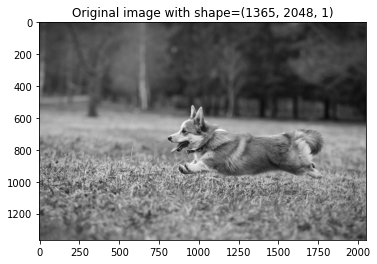

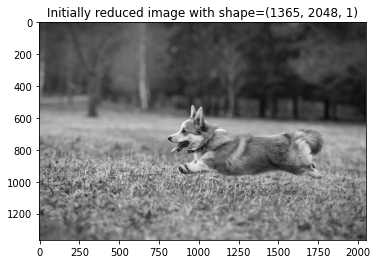

In [3]:
image = plt.imread(config.path)
image = image / 255.0
if config.grayscale:
    image = image.mean(axis=2, keepdims=True)
    
plt.figure()
plt.imshow(image, cmap='gray');
plt.title(f"Original image with shape={image.shape}");

image = pool_image(image, config.reduce_size_by_factor)
plt.figure()
plt.imshow(image, cmap='gray');
plt.title(f"Initially reduced image with shape={image.shape}");

In [4]:
# remove every other pixel from row and column
mask = jnp.zeros(image.shape, dtype=bool)
mask = mask.at[::3, ::3, :].set(True)
full_mask = mask.at[:, :, :].set(True)
all_coords = get_coords_for_image(image, (-1, 1), (-1, 1))
print(f"{all_coords.reshape(-1, 2).min(axis=0) = }, {all_coords.reshape(-1, 2).max(axis=0) = }")
print(f"{all_coords.shape=}, {image.shape=}")
print(f"{mask.sum()=}")

all_coords_flat = jnp.asarray(jax.vmap(lambda coords: coords[full_mask[:, :, 0]], in_axes=2, out_axes=1)(all_coords))
image_flat = jnp.asarray(image[full_mask][..., None])
print(f"{all_coords_flat.shape=}, {image_flat.shape=}")

# remove nan values
# coords = jax.vmap(lambda coords: coords[mask[:, :, 0]], in_axes=2, out_axes=1)(all_coords)
# reduced_image = jax.vmap(lambda image: image[mask[:, :, 0]], in_axes=2, out_axes=1)(image)
# print(f"{coords.shape=}, {reduced_image.shape=} % train percentage = {100*mask.sum() / mask.size}")

all_coords.reshape(-1, 2).min(axis=0) = array([-1., -1.]), all_coords.reshape(-1, 2).max(axis=0) = array([1., 1.])
all_coords.shape=(1365, 2048, 2), image.shape=(1365, 2048, 1)
mask.sum()=Array(310765, dtype=int32)
all_coords_flat.shape=(2795520, 2), image_flat.shape=(2795520, 1)


In [11]:
siren = SIREN(config.layers, 1)
siren_params = siren.init(config.key, jnp.ones((1, 2)))
flat_params, unravel_fn = ravel_pytree(siren_params)
print(f"{flat_params.shape=}")
encoder = Encoder([2048, 2048, 2048, 2048], len(flat_params))
partial_size = int(0.1 * all_coords.shape[0])
encoder_params = encoder.init(config.key, jnp.ones((1, all_coords.shape[-1])), jnp.ones((1, 1)))

def loss_fn(params, partial_x, partial_y, full_x, full_y):
    encoding = encoder.apply(params, partial_x, partial_y)
    siren_params = unravel_fn(encoding.ravel())
    pred_y = siren.apply(siren_params, full_x)
    return jnp.mean((pred_y - full_y) ** 2)

value_and_grad_fn = jax.value_and_grad(loss_fn)
opt = optax.adam(config.lr)
state = opt.init(encoder_params)

def one_step(params_and_state, key):
    params, state = params_and_state
    batch_idx = jax.random.choice(key, jnp.arange(all_coords_flat.shape[0]), shape=(partial_size,), replace=False)
    partial_x = all_coords_flat[batch_idx]
    partial_y = image_flat[batch_idx]
    
    loss, grads = value_and_grad_fn(params, partial_x, partial_y, all_coords_flat, image_flat)
    updates, state = opt.update(grads, state)
    params = optax.apply_updates(params, updates)
    return (params, state), loss

keys = jax.random.split(config.key, 10000)
(params, state), loss_history = jax.lax.scan(one_step, (encoder_params, state), keys)

flat_params.shape=(198401,)


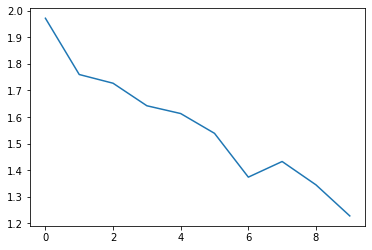

In [8]:
plt.plot(loss_history);

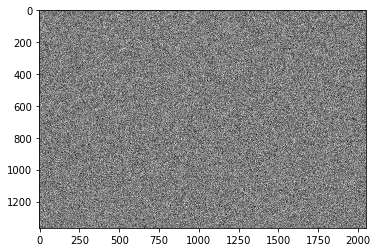

In [10]:
key = jax.random.PRNGKey(65432)
batch_idx = jax.random.choice(key, jnp.arange(all_coords_flat.shape[0]), shape=(partial_size,), replace=False)
partial_x = all_coords_flat[batch_idx]
partial_y = image_flat[batch_idx]
pred_params = encoder.apply(params, partial_x, partial_y)
pred_siren_params = unravel_fn(pred_params.ravel())
pred_y = siren.vapply(pred_siren_params, all_coords)

plt.imshow(pred_y, cmap='gray', interpolation="none");